<a href="https://colab.research.google.com/github/HannaKi/DL_HLT_2020_groupwork/blob/master/Text_Classification_task_Hanna_MS_3_pelkka_BERT_ja_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification

This project is about text classification. You will develop a text classification system that identifies different kinds of online texts, such as news, blogs and opinionated texts. We will refer to these text categories as registers. If you want to learn more about online registers and their automatic identification, you can read, e.g., our paper [Toward Multilingual Identification of Online Registers] (https://www.aclweb.org/anthology/W19-6130/).

# Data and register labels
The data for this project consist of ~7500 documents with manual annotations on their register. You can download it from http://dl.turkunlp.org/TKO_8965-projects/classification/ . The documents are based on a (almost) random sample of the Finnish Internet. The registers are identified using a relatively detailed, hierarchical taxonomy. The taxonomy consists of 8 main categories that are divided into a large number of subregisters. The taxonomy is described at the end of this page. The table includes also the abbreviations that are used in the data.

The challenge with online documents is that it is not always easy to identify the specific registers categories of the documents. Furthermore, another issue is that a document may display characteristics of several registers. For instance, a blog post may simultaneously seem like a product review. To deal with these challenges, we have followed the following guidelines:
* For each document, the annotators have aimed at marking the specific subregister category. When this is possible, the document has two register labels: the subregister label and the main register label to which the subregister belongs. For instance, a document annotated as a news article would have the label NE for News and the corresponding higher level register label NA for Narrative. 
* In some cases, the document does not seem to fit any of the subregisters. In this case, the document can be given only one label: the main register label, such as NA for Narrative. 
* Some documents may display characteristics of several register categories. In this case, the annotator can mark several register labels for one single document. Consequently, the document may have up to four labels. This would be the case case if a document is annotated both as a Personal blog (subregister label PB + corresponding higher level register label NA) and Review (subregister label RV + corresponding higher level register label OP).


# Register classes and abbreviations

NA Narrative

* NE NA    New reports / news blogs
* SR NA    Sports reports
* PB NA    Personal blog
* HA NA    Historical article
* FC NA    Fiction
* TB NA    Travel blog
* CB NA    Community blogs
* OA NA    Online article

OP  Opinion
* OB OP  Personal opinion blogs
* RV OP  Reviews
* RS OP  Religious blogs/sermons
* AV OP  Advice

IN Informational description
* JD IN  Job description
* FA IN  FAQs
* DT IN  Description of a thing
* IB IN  Information blogs
* DP IN  Description of a person
* RA IN  Research articles
* LT IN  Legal terms / conditions
* CM IN  Course materials
* EN IN  Encyclopedia articles
* RP IN  Report

ID Interactive discussion
* DF ID  Discussion forums
* QA ID  Question-answer forums

HI  How-to/instructions
* RE HI  Recipes

IP IG  Informational persuasion
* DS IG  Description with intent to sell
* EB IG  News-opinion blogs / editorials

Lyrical LY
* PO LY  Poems
* SL LY  Songs

Spoken SP
* IT SP Interviews
* FS SP Formal speeches

Others OS
* MT OS Machine-translated / generated texts


# Preparations


Import packages, set up TF version 1.

In [144]:
# Get rid of old tf at some point!

%tensorflow_version 1.x
# to run with old tf with which the code was made
# The default version of TensorFlow in Colab will switch to TensorFlow 2.x on the 27th of March, 2020.
# https://colab.research.google.com/notebooks/tensorflow_version.ipynb

import tensorflow
print(tensorflow.__version__)

1.15.2


In [145]:
print(tensorflow.keras.__version__)

2.2.4-tf


In [146]:
!pip install h5py

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random
import os

from pprint import pprint
from datetime import datetime

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier

%matplotlib inline

For saving the models

In [0]:
%%script bash
mkdir -p models

Download and open data, explore it.

In [149]:
# Download development data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
# Download test data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
# Download train data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-train.tsv

--2020-05-09 18:50:42--  http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4035578 (3.8M) [application/octet-stream]
Saving to: ‘fincore-dev.tsv.4’

fincore-dev.tsv.4   100%[===================>]   3.85M  3.46MB/s    in 1.1s    

2020-05-09 18:50:43 (3.46 MB/s) - ‘fincore-dev.tsv.4’ saved [4035578/4035578]

--2020-05-09 18:50:44--  http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8512687 (8.1M) [application/octet-stream]
Saving to: ‘fincore-test.tsv.4’

fincore-test.tsv.4  100%[===================>]   8.12M  6.54MB/s    in 1.2s    

2020-05-09 18:50:46 (6.

Data split

- Training set: used for training the models
- Validation (or model assessment) set: when comparing
dierent models trained on training set, select one with lowest
error on validation set
- Test set: test the nal hypothesis on test set to get unbiased
error estimate for it

After error estimation the nal model is often trained on
combined training, validation and test set, using best
hyperparameters found during model selection
- Complication: randomized optimization approaches where
dierent runs with same hyperparameters can lead to very
dierent quality solutions (e.g. neural network)



In [189]:
train = pd.read_csv('fincore-train.tsv', sep='\t', header=None)

train = train.sample(frac=1, random_state = 4) # suffle the data
train.columns = ['label','text']
print("train data")
print(train.head())
print(train.shape)
#print("Label counts:")
# print(train['label'].value_counts())

dev = pd.read_csv('fincore-dev.tsv', sep='\t', header=None)
dev.columns = ['label','text']
print("dev data")
print(dev.head())
print(dev.shape)
#print("Label counts:")
# print(dev['label'].value_counts())

test = pd.read_csv('fincore-test.tsv', sep='\t', header=None)
test.columns = ['label','text']
print("test data")
print(test.head())
print(test.shape)
#print("Label counts:")
# print(test['label'].value_counts())

test_text = test['text']
test_labels = test['label']

train data
       label                                               text
3982  DS IG    Logistiikka Jenni Lindholm Laskutus Ritva Lie...
2640  RS OP    Tässä [ [ Ortodoksinen seminaari ( Joensuu ) ...
119   NE NA    Koulutuspaikka jokaiselle peruskoulun päättän...
4916  SR NA    1 Cardiff C–Everton Tasainen kohde . Cardiff ...
775   MT OS    Northrop Grumman Q4 2009 tulokset Northrop Gr...
(5295, 2)
dev data
    label                                               text
0  OA NA    Luonnonhoito Maaperän siemenpankkia avattiin ...
1  DS IG    • Jokainen ripsi on erittäin kevyt ja muodolt...
2  DS IG    Mukavuudet Hotel Dila Vain muutaman metrin pä...
3  DF ID    Vastaa viestiin Otsikko Viesti ensin omaishoi...
4  OA NA    Dinosaur Jr 30.5.2010 Tavastia , Helsinki 198...
(756, 2)
test data
    label                                               text
0    HI     Tehkää nollaleimaus . Jos rekisteröinti onnis...
1    NA     1 kommenttia : Syyslomallelähtijät kirjoitti ...
2  DT IN    Ammatt

In [190]:
# Prepare stratified data sets for training, development and testing:
# Stratification aims to ensure that all the data sets (train, development and test) have the same distribution of labels. 
# This minimizes chances that a model has to try to predict labes it has not seen during training.

# test-train-split causes error: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
# Best solution: More data
# Second best solution: If you cannot have another dataset, you will have to play with what you have. Suggestion: remove the sample that has the lonely target. 

# Join all the data and re-divide it with stratification and to illustrate how skewed the data is!
train_e = train
train_e['data'] = 'train'

dev_e = dev
dev_e['data'] = 'dev'

test_e = test
test_e['data'] = 'test'

frames = [train_e, dev_e, test_e]
df = pd.concat(frames).reset_index(drop=True) # get rid of the old indexes # this data used for milestone 3

# Separating out the target
y = df['label'] # pd df
# # Separating out the features
X = df['text'] # pd df

unique, counts = np.unique(y, return_counts=True)
nums = dict(zip(unique, counts))

df.head()

#pprint(sorted(nums.items(), key = lambda kv:(kv[1], kv[0])))

,label,text,data
0,DS IG,Logistiikka Jenni Lindholm Laskutus Ritva Lie...,train
1,RS OP,Tässä [ [ Ortodoksinen seminaari ( Joensuu ) ...,train
2,NE NA,Koulutuspaikka jokaiselle peruskoulun päättän...,train
3,SR NA,1 Cardiff C–Everton Tasainen kohde . Cardiff ...,train
4,MT OS,Northrop Grumman Q4 2009 tulokset Northrop Gr...,train


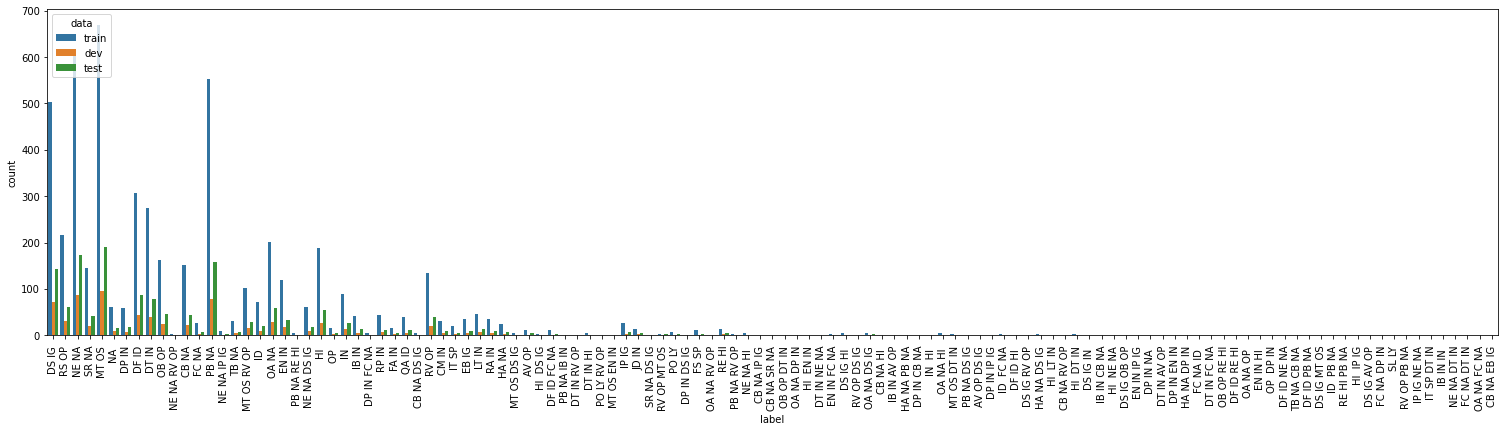

In [9]:
plt.figure(figsize=(26, 6))
plt.xticks(rotation=90)
sns.countplot(x="label", hue="data", data=df)

As we can see, the distribution of labels is highly skewed. This might be fixed with data augmentation. 

# Baseline

Since we now know that 'MT OS ' is the most common label in the data with 957 occurences, we can set a naive baseline prediction: We will predict that an unlabeled new text belongs to this biggest class. In this case our prediction accuracy is the pure share of the biggest class in the data:

In [0]:
print("Classification baseline: ", round((957/df.shape[0])*100,1), "percent") # here the original data without modifications for training of classificators 

Classification baseline:  12.7 percent


# Milestone 1.1: Bag-of-words classifier (multi-class)

Train a bag-of-words classifier to predict the register categories. In this milestone, the setting is multi-class, so the register label combinations form the classes, e.g. NA_NE and NA_NE_OP_OB. 

- Evaluate your model and report your results with different hyperparameters
- Ideas to try:
  - Different activation functions
  - Altering the learning rate
  - Use different optimizers
  - Adjusting the vocabulary size of the embeddings

- Activation functions and optimizers supported by Keras can be found here: https://keras.io/


Bow classifier is only interested in the multiplicity or appearance of words (or to be precise n-garms). Hence we loose the textual context and order of the words (n-grams). This inevitably leads to some information loss.

## Data filtering  for milestones 1 and 2

Since we can not train the model to predict labels it has not seen during training phase, we will keep only rows in dev and test data which have the labels that appear also in training data

In [0]:
# Optional way to treat data if stratification is bad idea...

# Gather features and labels of the data

# Separate text and the associated label
train_text = train['text']
train_labels = train['label']

# print(train_text.head())
# print(train_labels.head())
# print()

dev_text = dev['text']
dev_labels = dev['label']

test_text = test['text']
test_labels = test['label']

labels = [train_labels, dev_labels, test_labels]
all_labels = pd.concat(labels)

print(all_labels.head(10))
print()
print("Number of unique labels in data: ", len(all_labels.unique()))

3982    DS IG 
2640    RS OP 
119     NE NA 
4916    SR NA 
775     MT OS 
5264      NA  
5040    DP IN 
3446    DS IG 
216     DF ID 
863     DT IN 
Name: label, dtype: object

Number of unique labels in data:  119


In [0]:
print("Number of unique labels in")
print("-train data: ", len(np.unique(train_labels)))
print("-development data: ", len(np.unique(dev_labels)))
print("-test data: ", len(np.unique(test_labels)))
print()
inter = np.intersect1d(train_labels, dev_labels)
inter2 = np.intersect1d(train_labels, test_labels)
print("Number of shared labels in")
print("-train and development data: ", len(inter))
print("-train and test data: ", len(inter2))

Number of unique labels in
-train data:  100
-development data:  58
-test data:  70

Number of shared labels in
-train and development data:  52
-train and test data:  57


In [0]:
# Filter out labels not found in training data

test_ = test[test['label'].isin(train_labels.tolist())]
dev_ = dev[dev['label'].isin(train_labels.tolist())] 

print(test_.shape)
print(dev_.shape)

dev_text = dev_['text'] # development data for milestones 1 and 2
dev_labels = dev_['label']

test_text = test_['text'] # test data for milestones 1 and 2
test_labels = test_['label']

labels = [train_labels, dev_labels, test_labels]
labels = pd.concat(labels)

print("Number of unique labels in data: ", len(labels.unique()))

(1500, 3)
(750, 3)
Number of unique labels in data:  100


In [0]:
print("Number of unique labels in")
print("-train data: ", len(np.unique(train_labels)))
print("-development data: ", len(np.unique(dev_labels)))
print("-test data: ", len(np.unique(test_labels)))
print()
inter = np.intersect1d(train_labels, dev_labels)
inter2 = np.intersect1d(train_labels, test_labels)
print("Number of shared labels in")
print("-train and development data: ", len(inter))
print("-train and test data: ", len(inter2))

Number of unique labels in
-train data:  100
-development data:  52
-test data:  57

Number of shared labels in
-train and development data:  52
-train and test data:  57


## Data preparation, step  1: form feature matrix

We will use CountVectorizer / TfidfVectorizer from sklearn package to transform out text data to numerical format with which our classifier is able to deal with. CountVectorizer converts the collection of text documents (our training data) to a matrix of token counts. Since we are only interested in whether a particular word of the vocabulary is in a single document or not, our vectorizer is set on "binary". 

In [0]:
vectorizer = TfidfVectorizer(max_features = 20000, ngram_range = (1,1)) # Grid search fails: OOM when allocating tensor of shape [85000,200]

# form feature matrix
train_feature_matrix = vectorizer.fit_transform(train_text)
dev_feature_matrix = vectorizer.transform(dev_text)
test_feature_matrix = vectorizer.transform(test_text)

print("shape of the training data: ", train_feature_matrix.shape)
print("shape of the development data: ", dev_feature_matrix.shape)


shape of the training data:  (5295, 20000)
shape of the development data:  (750, 20000)


The shape of the feature matrix tells us that we have XXX items (documents) in our training data. The number of unique n-grams exceeds XXXX but we are including only the first XXXX most common of them. Since our CountVectorizer has parameter setting "ngram_range = 1, 1" this means we are forming the vector with unigrams, separate words or charachters.

## Data preparation, step 2: Label encoding and one hot encoding

Next we will encode the labels. This means transforming the textual labels to numeric values, which our model is able to deal with. This step is made with LabelEncoder class.

In [0]:
# label encoding 

label_encoder = LabelEncoder() # Create the instance of LabelEncoder we use to turn class labels into integers

train_numbers = label_encoder.fit_transform(train_labels) # encode labels to integers
dev_numbers = label_encoder.transform(dev_labels) 
test_numbers = label_encoder.transform(test_labels) 

print("Inverse transform gives unique labels in each data set: ", label_encoder.inverse_transform(train_numbers))
print("Sanity checks, do we have as many labels and texts in our data sets?")
print("Train data: ", len(train_numbers), len(train_text))
print("Dev data: ", len(dev_numbers), len(dev_text))
print("Test data: ", len(test_numbers), len(test_text))

# one hot encoding

one_hot_encoder = OneHotEncoder(sparse=False)
train_hot=one_hot_encoder.fit_transform(train_numbers.reshape(-1,1))
dev_hot=one_hot_encoder.transform(dev_numbers.reshape(-1,1))
test_hot=one_hot_encoder.transform(test_numbers.reshape(-1,1))
print()
print(train_hot.shape)
print(dev_hot.shape)
print(test_hot.shape)
train_hot

Inverse transform gives unique labels in each data set:  ['DS IG ' 'RS OP ' 'NE NA ' ... 'DS IG ' 'MT OS ' 'MT OS ']
Sanity checks, do we have as many labels and texts in our data sets?
Train data:  5295 5295
Dev data:  750 750
Test data:  1500 1500

(5295, 100)
(750, 100)
(1500, 100)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
# LabelEncoderin testailua ÄLÄ HÄVITÄ!!!!!!

# le = LabelEncoder()
# le.fit(["paris", "paris", "tokyo", "amsterdam"]) # encode tee koodaus
# print("Koodaukset: ", list(le.classes_))
# print()
# le.transform(["tokyo", "tokyo", "paris"]) # käytä koodausta arvojen transformointiin --> numeeriset arvot
# num = le.transform(["tokyo", "tokyo", "paris"])
# print("Sovitetulla encoderilla tuotetut numeeriset arvot muuttujalistasta: ", num)
# print()
# print("Inverse transform: ", list(le.inverse_transform([2, 2, 1])))
# print()
# test = le.fit_transform(["paris", "paris", "tokyo", "amsterdam"]) # encode and transform
# print("Koodit kolmella", test)

# le.fit(["paris", "paris", "tokyo", "amsterdam", "helsinki"])
# #print(list(le.classes_))

# test = le.fit_transform(["paris", "helsinki", "tokyo", "amsterdam"]) # encode and transform
# print("Koodit neljällä", test)

# print(list(le.inverse_transform([2, 2, 1])))


Now the data is prepared for milestone 1.

## Cross validation and hyperparameter optimization with Gridsearch

Join train and dev data for CV grid search.

Approach: Select prominent optimizers and optimize rest of the hyperparams for it. Since other hyperparams affect the optimizer performance it is not a "fair competition" to optimize optimizers with all the rest hyperparams set to some values. We have to deal with memory constraints also. This significantly limits the set of hyperparametrs we can optimize at once.

Here Adam and SGD are explored.

In [0]:
# Data preparation

# features 
frames = [train, dev_]
joint = pd.concat(frames)
joint_feature_matrix = vectorizer.fit_transform(joint['text'])

# labels, one hot encoded
print(type(train_hot))
print(train_hot.shape)
print(dev_hot.shape)
joint_labels= np.concatenate((train_hot, dev_hot))
print(joint_labels.shape)

print(joint_feature_matrix.shape)

<class 'numpy.ndarray'>
(5295, 100)
(750, 100)
(6045, 100)
(6045, 20000)


## Optimizer: SGD

### Step 1.1 Build and compile model

In [0]:
example_count, feature_count = joint_feature_matrix.shape
class_count = len(labels.unique())

def create_bow_model_SGD(learning_rate=0.01, nodes=200):
  inp = Input(shape=(feature_count,))
  hidden1 = Dense(nodes, activation="relu")(inp)
 # hidden2 = Dense(nodes, activation="relu")(hidden1) # multiple hidden layers possible but slow down hyperparameter optimization
  dropout = Dropout(0.3)(hidden1)
  outp = Dense(class_count, activation='softmax')(dropout)
  model = Model(inputs=[inp], outputs=[outp])
  optimizer = optimizers.SGD(learning_rate=learning_rate) # also hyperparameter momentum could be optimized
  model.compile(optimizer = optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

In [0]:
model = create_bow_model_SGD()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
Total params: 4,020,300
Trainable params: 4,020,300
Non-trainable params: 0
_________________________________________________________________


### Step 1.2: GridSearch

In [0]:
#tensorflow.compat.v1.disable_eager_execution()
stop_cb = EarlyStopping(monitor = 'accuracy', patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

# If the error only occurs when you use smaller datasets, you're very likely using datasets small enough to not have a single sample in the validation set. 

bow_model_SGD = KerasClassifier(build_fn=create_bow_model_SGD, epochs=40, batch_size=32, verbose=1)

In [0]:
start = datetime.now()
print("start time =", start)

# set the hyperparameter: example: np.logspace(-10, 1, num = 7, base = 2)
learning_rate = np.logspace(-7, 0, num = 5, base = 2).tolist()
params = dict(learning_rate = learning_rate)

grid = GridSearchCV(estimator = bow_model_SGD, param_grid = params, n_jobs = 1, cv = 3 , verbose  = 1)  # cv: For integer/None inputs, if the estimator is a classifier and y is 
                                                                                                        # either binary or multiclass, StratifiedKFold is used.
X = joint_feature_matrix.toarray()
    
grid_result_SGD = grid.fit(X, joint_numbers, callbacks=[stop_cb, mc_cb])

end = datetime.now()
print("end time =", end)

start time = 2020-05-01 10:54:05.028913
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/40
4030/4030 [==============================] - 1s 273us/step - loss: 4.5955 - accuracy: 0.0787
Epoch 2/40
4030/4030 [==============================] - 1s 158us/step - loss: 4.5714 - accuracy: 0.1328
Epoch 3/40
4030/4030 [==============================] - 1s 160us/step - loss: 4.5463 - accuracy: 0.1340
Epoch 4/40
4030/4030 [==============================] - 1s 161us/step - loss: 4.5197 - accuracy: 0.1380
Epoch 5/40
4030/4030 [==============================] - 1s 158us/step - loss: 4.4928 - accuracy: 0.1385
Epoch 6/40
4030/4030 [==============================] - 1s 159us/step - loss: 4.4656 - accuracy: 0.1355
Epoch 7/40
4030/4030 [==============================] - 1s 160us/step - loss: 4.4367 - accuracy: 0.1414
Epoch 8/40
4030/4030 [==============================] - 1s 159us/step - loss: 4.4078 - accuracy: 0.1422
Epoch 9/40
4030/4030 [==============================] - 1s 159us/step - loss: 4.3778 - accuracy: 0.1370
Epoch 10/40
4030/4030 [==============================] - 1s 160u

KeyboardInterrupt: ignored

In [0]:
print("Best: %f using %s" % (grid_result_SGD.best_score_, grid_result_SGD.best_params_))

means = grid_result_SGD.cv_results_['mean_test_score']
stds = grid_result_SGD.cv_results_['std_test_score']
params = grid_result_SGD.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.553846 using {'learning_rate': 1.0}
0.130356 (0.007660) with: {'learning_rate': 0.0078125}
0.234243 (0.024834) with: {'learning_rate': 0.026278012976678578}
0.406286 (0.022258) with: {'learning_rate': 0.08838834764831845}
0.526882 (0.004518) with: {'learning_rate': 0.29730177875068026}
0.553846 (0.003991) with: {'learning_rate': 1.0}


### Step 1.3. Predict 

Now we can predict directly with optimized hyperparameters by calling "grid_result.predict"

In [0]:
test_feature_matrix = vectorizer.fit_transform(test_text)
print(test_feature_matrix.shape)

predictions_SGD = grid_result_SGD.predict(test_feature_matrix)
predicted_labels_SGD = label_encoder.inverse_transform(list(predictions_SGD))
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels_SGD)*100,1), "percent")

(1500, 20000)
1500/1500 [==============================] - 0s 202us/step
Classification accuracy:  6.4 percent


### Nested CV with SGD

In [0]:

# How to choose number of splits: https://machinelearningmastery.com/k-fold-cross-validation/

stop_cb = EarlyStopping(monitor = 'val_accuracy', patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

inner_cv = KFold(n_splits=3, shuffle=True, random_state=4) # Should use StratifiedKFold but can not because the smallest classes!
outer_cv = KFold(n_splits=3, shuffle=True, random_state=4)

# Inner CV: optimize number hyperparameter
# Set up possible values of parameters to optimize over
learning_rate = np.logspace(-7, 0, num = 5, base = 2).tolist()
params = dict(learning_rate = learning_rate)

nested_grid_SGD = GridSearchCV(estimator=bow_model_SGD, param_grid=params, n_jobs=1, cv=inner_cv, verbose = 1)

nested_grid_result_SGD = nested_grid_SGD.fit(X, joint_numbers, callbacks = [stop_cb])
print()

In [0]:
print("Best: %f using %s" % (nested_grid_result_SGD.best_score_, nested_grid_result_SGD.best_params_))

means = nested_grid_result_SGD.cv_results_['mean_test_score']
stds = nested_grid_result_SGD.cv_results_['std_test_score']
params = nested_grid_result_SGD.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.557982 using {'learning_rate': 1.0}
0.119438 (0.005350) with: {'learning_rate': 0.0078125}
0.236559 (0.048157) with: {'learning_rate': 0.026278012976678578}
0.409429 (0.003865) with: {'learning_rate': 0.08838834764831845}
0.528371 (0.003851) with: {'learning_rate': 0.29730177875068026}
0.557982 (0.005905) with: {'learning_rate': 1.0}


In [0]:
predictions_nested_SGD = nested_grid_result_SGD.predict(test_feature_matrix)
predicted_labels_nested_SGD = label_encoder.inverse_transform(list(predictions_nested_SGD))
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels_nested_SGD)*100,1), "percent")

1500/1500 [==============================] - 1s 489us/step
Classification accuracy:  7.4 percent


## Optimizer: Adam

In [0]:
X = joint_feature_matrix.toarray()


In [0]:
example_count, feature_count = joint_feature_matrix.shape
class_count = len(train_labels.unique())

def create_bow_model_Adam(learning_rate=0.01, nodes=200):
  inp = Input(shape=(feature_count,))
  hidden1 = Dense(nodes, activation="relu")(inp)
  hidden2 = Dense(nodes, activation="relu")(hidden1)                                          # two hidden layers
  dropout = Dropout(0.3)(hidden2)
  outp = Dense(class_count, activation='softmax')(dropout)                                    # also dropoutrate could be optimized
  model = Model(inputs=[inp], outputs=[outp])
  optimizer = optimizers.Adam(learning_rate=learning_rate)                                    # also hyperparameter momentum could be optimized
  model.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics=['accuracy']) # for one hot encodings
  return model

In [0]:
model = create_bow_model_Adam()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
Total params: 4,060,500
Trainable params: 4,060,500
Non-trainable params: 0
_________________________________________________________________


## Nested cross-validation
- nested, aka external cross-validation
- cross-validation within cross-validation
- inner loop for model selection, outer for evaluation
- Split the data to K non-overlapping folds
1. designate i:th fold as the outer cross-validation test fold, set it
aside
2. use the remaining K-1 folds to perform model selection with
cross-validation as usual
3. train the model with selected parameters on the K-1 training
folds
4. compute predictions using the remaining ith fold as test set
I afterwards collect the together predictions made at step 4 for
all the K folds and compute your error rate or other
performance measure

In [0]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
# https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
# https://mlfromscratch.com/nested-cross-validation-python-code/#/

# Choose cross-validation techniques for the inner and outer loops
# outer loop: X folds
# inner loop: each fold of outer loop is folded again! To avoid too heavy computaion do not fold too many times or try running parallel 
# (n_jobs=-1): parallel, (n_jobs=1): sequential

start = datetime.now()
print("start time =", start)

bow_model_Adam = KerasClassifier(build_fn=create_bow_model_Adam, epochs=40, batch_size=100, verbose=0)

# Call backs won't work / not needed with gridsearch... 
# stop_cb = EarlyStopping(monitor = 'val_accuracy', patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
# Warning: 'val_accuracy' not available: Stack overflow search suggestion: "If the error only occurs when you use smaller datasets, 
# you're very likely using datasets small enough to not have a single sample in the validation set. "
# mc_cb = ModelCheckpoint(filepath='models/bow_model.h5', monitor='val_accuracy', verbose=0,save_best_only=True, mode='auto')
# Warning: memory leak

inner_cv = KFold(n_splits=3, shuffle=True, random_state=4) # Should use StratifiedKFold but can not because the smallest classes!
outer_cv = KFold(n_splits=3, shuffle=True, random_state=4)

learning_rate = [0.005, 0.001, 0.01, 0.1]
epochs = [20, 40]
params = dict(learning_rate=learning_rate, epochs = epochs )

nested_grid_Adam = GridSearchCV(estimator=bow_model_Adam, param_grid=params, n_jobs=-1, cv=inner_cv, verbose = 1)

nested_grid_result_Adam = nested_grid_Adam.fit(X, joint_labels, verbose = 1, callbacks=[mc_cb])

end = datetime.now()
print("start time =", end)

start time = 2020-05-05 16:06:13.958064
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min finished


Train on 6045 samples
Epoch 1/40
6045/6045 [==============================] - 2s 295us/sample - loss: 3.4626 - acc: 0.2328
Epoch 2/40
6045/6045 [==============================] - 1s 127us/sample - loss: 2.1551 - acc: 0.4907
Epoch 3/40
6045/6045 [==============================] - 1s 128us/sample - loss: 1.5263 - acc: 0.6467
Epoch 4/40
6045/6045 [==============================] - 1s 128us/sample - loss: 1.0313 - acc: 0.7658
Epoch 5/40
6045/6045 [==============================] - 1s 125us/sample - loss: 0.6438 - acc: 0.8653
Epoch 6/40
6045/6045 [==============================] - 1s 127us/sample - loss: 0.3959 - acc: 0.9327
Epoch 7/40
6045/6045 [==============================] - 1s 126us/sample - loss: 0.2492 - acc: 0.9643
Epoch 8/40
6045/6045 [==============================] - 1s 131us/sample - loss: 0.1689 - acc: 0.9745
Epoch 9/40
6045/6045 [==============================] - 1s 127us/sample - loss: 0.1270 - acc: 0.9800
Epoch 10/40
6045/6045 [==============================] - 1s 126us/sam

KeyboardInterrupt: ignored

In [0]:
print("Best: %f using %s" % (nested_grid_result_Adam.best_score_, nested_grid_result_Adam.best_params_))

means = nested_grid_result_Adam.cv_results_['mean_test_score']
stds = nested_grid_result_Adam.cv_results_['std_test_score']
params = nested_grid_result_Adam.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print()
predictions_nested_Adam = nested_grid_result_Adam.predict(test_feature_matrix)
predicted_labels_nested_Adam = label_encoder.inverse_transform(list(predictions_nested_Adam))
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels_nested_Adam)*100,1), "percent")

Best: 0.548883 using {'epochs': 20, 'learning_rate': 0.001}
0.535318 (0.004333) with: {'epochs': 20, 'learning_rate': 0.005}
0.548883 (0.007505) with: {'epochs': 20, 'learning_rate': 0.001}
0.522581 (0.010179) with: {'epochs': 20, 'learning_rate': 0.01}
0.303888 (0.021451) with: {'epochs': 20, 'learning_rate': 0.1}
0.190240 (0.041566) with: {'epochs': 20, 'learning_rate': 0.2}
0.532672 (0.014120) with: {'epochs': 40, 'learning_rate': 0.005}
0.541935 (0.008314) with: {'epochs': 40, 'learning_rate': 0.001}
0.489992 (0.001638) with: {'epochs': 40, 'learning_rate': 0.01}
0.338792 (0.025922) with: {'epochs': 40, 'learning_rate': 0.1}
0.119107 (0.009950) with: {'epochs': 40, 'learning_rate': 0.2}

Classification accuracy:  13.8 percent


In [0]:
# This took like ages and ended up with disconnected runtime!!!!!!!!!!!!!!

# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
# # https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
# # https://mlfromscratch.com/nested-cross-validation-python-code/#/

# # Choose cross-validation techniques for the inner and outer loops
# # outer loop: N folds
# # inner loop: each fold of outer loop is folded again! To avoid too heavy computaion do not fold too many times or try running parallel

# bow_model_Adam = KerasClassifier(build_fn=create_bow_model_Adam, epochs=40, batch_size=100, verbose=0)

# stop_cb = EarlyStopping(monitor = 'val_accuracy', patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
# mc_cb = ModelCheckpoint(filepath='models/bow_model.h5', monitor='accuracy', verbose=0,save_best_only=True, mode='auto')

# inner_cv = KFold(n_splits=3, shuffle=True, random_state=4) # Should use StratifiedKFold but can not because the smallest classes!
# outer_cv = KFold(n_splits=3, shuffle=True, random_state=4)

# # Set the hyperparameter grid. Also possible hyperparams (when parametrized for the functions called!):
# # - dropout rate
# # - if optimizer is SGD, momentum
# # - max_feat (input shape)
# nodes = [100, 200]
# epochs = [40, 64]
# batch_size = [4, 10, 32]
# learning_rate = [0.0001, 0.001, 0.01]
# params = dict(learning_rate = learning_rate, nodes = nodes, epochs = epochs, batch_size = batch_size)

# nested_grid_Adam = GridSearchCV(estimator=bow_model_Adam, param_grid=params, n_jobs=1, cv=inner_cv, verbose = 1)

# nested_grid_result_Adam = nested_grid_Adam.fit(X, joint_labels, verbose = 1) #, callbacks=[stop_cb])


## Fitting BOW-classifier OLD

Now we will fit the data. Here we will also need the validation data. 
Let's try with different optimizers available in Keras.

In [0]:
example_count, feature_count = train_feature_matrix.shape
class_count = len(train_labels.unique()) 

inp = Input(shape = (feature_count, ))                   # Tuple. The size of the inputlayer is the number of the vectors
hidden = Dense(300, activation="relu")(inp)  
hidden2 = Dense(300, activation="relu")(hidden)
dropout = Dropout(0.3)(hidden2)                          # Non-linear activation function. tanh or relu? 
outp = Dense(class_count, activation="softmax")(hidden2) # As many output possibilities as we have input classes. 
                                                         # Softmax: produces probability distribution of the classes
bow_model = Model(inputs=[inp], outputs=[outp])

bow_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               6000300   
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
Total params: 6,120,700
Trainable params: 6,120,700
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Choose best OP and LR and fit the model
stop_cb = EarlyStopping(monitor = 'val_accuracy', patience=40, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

bow_model.compile(optimizer = 'Adam', loss="categorical_crossentropy", metrics=['accuracy']) # with one-hot encodings loss = categorical_crossentropy!!!

bow_history = bow_model.fit(train_feature_matrix, train_hot, batch_size=32, 
                 verbose=1, epochs=100, validation_data=(dev_feature_matrix, dev_hot), callbacks=[stop_cb])


Train on 5295 samples, validate on 750 samples
Epoch 1/100
5295/5295 [==============================] - 14s 3ms/step - loss: 2.6677 - accuracy: 0.3804 - val_loss: 1.9671 - val_accuracy: 0.5320
Epoch 2/100
5295/5295 [==============================] - 14s 3ms/step - loss: 1.2771 - accuracy: 0.7005 - val_loss: 1.7759 - val_accuracy: 0.5733
Epoch 3/100
5295/5295 [==============================] - 14s 3ms/step - loss: 0.4830 - accuracy: 0.8997 - val_loss: 1.8270 - val_accuracy: 0.5640
Epoch 4/100
5295/5295 [==============================] - 14s 3ms/step - loss: 0.1798 - accuracy: 0.9726 - val_loss: 1.9260 - val_accuracy: 0.5627
Epoch 5/100
5295/5295 [==============================] - 14s 3ms/step - loss: 0.0993 - accuracy: 0.9817 - val_loss: 1.9714 - val_accuracy: 0.5747
Epoch 6/100
5295/5295 [==============================] - 14s 3ms/step - loss: 0.0696 - accuracy: 0.9858 - val_loss: 2.1091 - val_accuracy: 0.5547
Epoch 7/100
5295/5295 [==============================] - 14s 3ms/step - loss

In [0]:
# form feature matrix for test data set
test_feature_matrix = vectorizer.fit_transform(test_text)
print(test_feature_matrix.shape)

(1500, 20000)


In [0]:
predictions = np.argmax(bow_model.predict(test_feature_matrix), axis=1) # np.argmax gives the index which has the highest value e.g. class
predicted_labels = label_encoder.inverse_transform(list(predictions))
print("predicted labels: \n", predicted_labels)
print()
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels)*100,1), "percent")

predicted labels: 
 ['NE NA ' 'NA  ' 'NA  ' ... 'NA  ' 'NA  ' 'PB NA ']

Classification accuracy:  9.0 percent


In [0]:
# Without np.argmax:

# predictions = bow_model.predict(test_feature_matrix) 
# predictions = one_hot_encoder.inverse_transform(predictions) # transfer form one hot encodings to numerical labels 
# predicted_labels = label_encoder.inverse_transform(list(predictions))
# print("predicted labels: \n", predicted_labels)
# print()
# print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels)*100,1), "percent")


predicted labels: 
 ['NE NA ' 'NA  ' 'NA  ' ... 'NA  ' 'NA  ' 'PB NA ']

Classification accuracy:  9.0 percent


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Why does the model perform so badly?

In [0]:

print("Number of unique labels in")
print("-train data: ", len(np.unique(train_numbers)))
print("-development data: ", len(np.unique(dev_numbers)))
print("-test data: ", len(np.unique(test_numbers)))
print()
inter = np.intersect1d(train_numbers, dev_numbers)
inter2 = np.intersect1d(train_numbers, test_numbers)
print("Number of shared labels in")
print("-train and development data: ", len(inter))
print("-train and test data: ", len(inter2))

In [0]:
# cnf_matrix = confusion_matrix(test_labels, predicted_labels)

# # Confusion matrix has the true labels on rows, and predicted labels on columns in sorted order
# print(cnf_matrix)

In [0]:
# # Plot confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes = all_labels, normalize = False)

# plt.show()

In [0]:
# # np-argmaxin testailua ÄLÄ HÄVITÄ!!!!!!
# print(predictions[0])
# print(model.predict(test_feature_matrix)[0][25])
# print(model.predict(test_feature_matrix)[0])
# print(sum(model.predict(test_feature_matrix)[0]))

# Milestone 1.2: Recurrent Neural Network Classifier (multi-class)

Modify your codes from milestone 1.1 to use recurrent neural networks (e.g. LSTM or biLSTM) in the classifier. Evaluate your model and report your results with different hyperparameters.

For RNN-calssifier we use Tokenizer which turns tokens, in our case the words of training data to integers. 

## Tokenizing

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=97000, # max num of most common words
)

tokenizer.fit_on_texts(train_text)

In [0]:
from pprint import pprint    # pretty-printer

def truncate_dict(d, count=10):
    # Returns at most count items from the given dictionary.  
    return dict(i for i, _ in zip(d.items(), range(count)))

# Check if 0 is in the index, and print examples of the mapping
# 0 is reserved for padding!
print(tokenizer.word_index.get(0))
pprint(truncate_dict(tokenizer.word_index))

None
{'ei': 3,
 'että': 4,
 'ja': 1,
 'kun': 9,
 'mutta': 8,
 'oli': 7,
 'on': 2,
 'ovat': 10,
 'se': 6,
 'tai': 5}


In [0]:
train_sequences = tokenizer.texts_to_sequences(train_text)

print(len(train_sequences)) 

# Print an example text, its corresponding sequence, and the tokens it represents
print('Text:', train_text[0][0:200]) # first item of the suffled data (index not 0!)
#print('Text:', train_text.head(1)[0:200]) # first item of the suffled data (index not 0!)
print('Sequence:', train_sequences[0][:10])
print('Mapped back:', [tokenizer.index_word[i] for i in train_sequences[0][:10]])

5295
Text:  Tämähän menee ihan hurjaksi muotihurjasteluksi . Jo toistamiseen tälle syksylle postauksen aiheena vaatetus . Mutta tämä liittyy tavallaan matkailuun . Ja katsokaa nyt näitä , mitkä maailman ihanimma
Sequence: [21429, 13274, 40282, 11697, 15340, 796, 657, 388, 12826, 3002]
Mapped back: ['logistiikka', 'jenni', 'lindholm', 'laskutus', 'ritva', 'ota', 'yhteyttä', 'nimi', 'puhelinnumero', 'sähköposti']


In [0]:
lengths = [len(s) for s in train_sequences]
print('Lengths:', lengths[:10], 'min:', min(lengths), 'max:', max(lengths), 'mean:', np.mean(lengths))

Lengths: [384, 921, 158, 194, 932, 388, 123, 384, 1577, 167] min: 0 max: 79136 mean: 583.0457034938621


## Padding

Since Keras demands for all of the input items (separate documents of our training data) to have the same length, we need to "pad" all but the longest document by filling in the "missing" number of words with zeros.


In [0]:
from keras.preprocessing.sequence import pad_sequences

sequence_length = np.floor(np.mean(lengths)).astype(int) # based on mean value of input length: we will cut sequences longer than this and pad with zeros sequeces shorter than this

type(sequence_length)

padded_X = pad_sequences(
    train_sequences,
    maxlen = sequence_length, 
    value=0
)

print(padded_X.shape)

(5295, 583)


In [0]:
# Prepare model development data

dev_sequences = tokenizer.texts_to_sequences(dev_text)
padded_dev = pad_sequences(
    dev_sequences,
    maxlen = sequence_length, 
    value=0
)

print(padded_dev.shape)

(750, 583)


## LSTM RNN

## HUOMAA!!!
Tämä teksti alkuperäisestä RNN-classification notebookista!

We define a basic RNN model that takes the RNN cell class (RNN_class) as an argument:

- input: sequence of sequence_length integers corresponding to words
- embedding: randomly initialized mapping from integers to embedding_dim-dimensional vectors
- rnn: recurrent neural network with rnn_units-dimensional state
- output: num_classes-dimensional fully connected layer with softmax activation

# KATSO NÄITÄ!
We're intentionally leaving out a few fairly obvious things that would be expected to help here, including

- Any form of regularization, e.g. dropout
- Initializing the embeddings with pre-trained word vectors (ks. fasttext)
- Masking to ignore padding (see Masking and padding with Keras)


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# We'll use these model parameters for all of our examples here.
embedding_dim = 50 # input vector
rnn_units = 100

def build_rnn_model(RNN_class, sequence_length, vocab_size, num_classes):
    input_ = Input(shape=(sequence_length,))
    embedding = Embedding(vocab_size, embedding_dim)(input_) # randomly initialized. Layer turns positive integers (indexes) into dense vectors of fixed size
    rnn = RNN_class(rnn_units)(embedding) # can support different RNNs
    output = Dense(num_classes, activation='softmax')(rnn)
    return Model(inputs=[input_], outputs=[output])

sequence_length = padded_X.shape[1]
vocab_size = tokenizer.num_words
num_classes = len(label_encoder.classes_)

In [0]:
len(label_encoder.classes_)

In [0]:
lstm_model = build_rnn_model(LSTM, sequence_length, vocab_size, num_classes)

lstm_model.summary()

In [0]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 100
stop_cb = EarlyStopping(monitor = 'val_acc', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
lstm_history = lstm_model.fit(padded_X, train_numbers, epochs = epochs, batch_size = batch_size, validation_data=(padded_dev, dev_numbers), callbacks=[stop_cb])
# , callbacks=[stop_cb]

In [0]:
# Prepare model test data

test_sequences = tokenizer.texts_to_sequences(test_text)
padded_test = pad_sequences(
    test_sequences,
    maxlen = sequence_length, 
    value=0
)

print(padded_test.shape)

Predict with LSTM


In [0]:
predictions = np.argmax(lstm_model.predict(padded_test), axis=1) # np.argmax gives the index which has the highest value e.g. class
predicted_labels = label_encoder.inverse_transform(list(predictions))
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels)*100,1), "percent")

## Bidirectional LSTM RNN

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, Bidirectional, LSTM

# def build_bi_rnn_model(RNN_class, sequence_length, vocab_size, num_classes):
#     input_ = Input(shape=(sequence_length,))
#     embedding = Embedding(vocab_size, embedding_dim)(input_) # randomly initialized
#     rnn = Bi(RNN_class(rnn_units))(embedding) # can support different RNNs
#     output = Dense(num_classes, activation='softmax')(rnn)
#     return Model(inputs=[input_], outputs=[output])

model = Sequential()
# model.add(Input(shape=(sequence_length,)
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
model.add(Bidirectional(LSTM(rnn_units))) # bidirectional: num of neurons gets doubled
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, Bidirectional, LSTM

# def build_bi_rnn_model(RNN_class, sequence_length, vocab_size, num_classes):
#     input_ = Input(shape=(sequence_length,))
#     embedding = Embedding(vocab_size, embedding_dim)(input_) # randomly initialized
#     rnn = Bi(RNN_class(rnn_units))(embedding) # can support different RNNs
#     output = Dense(num_classes, activation='softmax')(rnn)
#     return Model(inputs=[input_], outputs=[output])

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
model.add(Bidirectional(LSTM(rnn_units))) # bidirectional: num of neurons gets doubled
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [0]:
stop_cb = EarlyStopping(monitor = 'val_accuracy', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
hist_bi_lstm = model.fit(padded_X, train_numbers, epochs = epochs, batch_size = batch_size, validation_data=(padded_dev, dev_numbers), callbacks=[stop_cb])

Predict with bi-directional LSTM

In [0]:
predictions = np.argmax(model.predict(padded_test), axis=1) # np.argmax gives the index which has the highest value e.g. class
predicted_labels = label_encoder.inverse_transform(list(predictions))
print("Classification accuracy: ", round(accuracy_score(test_labels, predicted_labels)*100,1), "percent")

# Milestone 2.1: Deep contextual representations with Bert (multi-class)
Train a Bert classifier to predict the register categories. Similar to Milestone 1, the setting is multi-class, and the evaluations should include results with different hyperparameters.

Neural language models trained on large
unannotated corpora can be used to create
contextualized representations of
meaning

[How-to](https://github.com/HannaKi/Deep_Learning_in_LangTech_course/blob/master/bert_text_classification_extended_comments.ipynb)

Keep only labels (and texts which correspond to those labels) which appear in training data

In [0]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory
# Maximum number of examples to read
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

To avoid out of memory we have to limit the input size to MAX_EXAMPLES.

In [0]:
def truncate_data(data, MAX_EXAMPLES):
  if len(data) > MAX_EXAMPLES: # truncate data if needed to avoid OOM
    print('Note: truncating examples from {} to {}'.format(len(data), MAX_EXAMPLES)) # should take stratified subsample?
    data = data[:MAX_EXAMPLES]
  return(data)

In [12]:
# We use dev_ and test_ data sets which only have labels that appear in train data
# All the datas will be truncated if needed

train_ = truncate_data(train, MAX_EXAMPLES)
dev_ = truncate_data(dev, MAX_EXAMPLES)
test_ = truncate_data(test, MAX_EXAMPLES)

frames = [train_, dev_, test_]
for d in frames:
  print(d.shape)
  #print(d.head())

Note: truncating examples from 5295 to 1500
Note: truncating examples from 1513 to 1500
(1500, 3)
(756, 3)
(1500, 3)


In [13]:
# Miksi ei onnistu ensin ottaa päällekäiset labelit pois ja sitten leikata 1000:een?!?!?

train_labels = train_['label']

test_ = test_[test_['label'].isin(train_labels.tolist())]
dev_ = dev_[dev_['label'].isin(train_labels.tolist())] 

frames = [train_, dev_, test_]
for d in frames:
  print(d.shape)
  #print(d.head())

(1500, 3)
(746, 3)
(1476, 3)


In [153]:
!pip3 install keras-bert

Set an environment variable for keras-bert to use tensorflow.python.keras

In [0]:
os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

## Download pretrained FinBERT model

Download pretrained TurkuNLP FinBERT from: https://github.com/TurkuNLP/FinBERT and prepare it for use.

In [155]:
!wget -nc http://dl.turkunlp.org/finbert/bert-base-finnish-cased-v1.zip

# Give -n argument so that existing files aren't overwritten 
!unzip -n bert-base-finnish-cased-v1.zip

# Store paths to important files:

bert_vocab_path = 'bert-base-finnish-cased-v1/vocab.txt'
bert_config_path = 'bert-base-finnish-cased-v1/bert_config.json'
bert_checkpoint_path = 'bert-base-finnish-cased-v1/bert_model.ckpt' # suffixes not required

# 
model_is_cased = True

File ‘bert-base-finnish-cased-v1.zip’ already there; not retrieving.

Archive:  bert-base-finnish-cased-v1.zip


## Load vocabulary

In [156]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item (includes suffixes)
print(vocab[0::500]) # 0 is for padding!
print(vocab[103]) # tags are included

['[PAD]', '##hin', '##tila', 'tehtä', '##ce', 'avulla', '##uttua', 'Sil', '##iver', 'tarvits', 'kilometrin', 'sanotaan', '##ya', 'onnistuu', 'tapaus', 'rento', '##otin', '##kasvat', 'kauhe', 'puolin', 'ymmärrän', 'polttoain', 'arvot', 'ajattelu', '##impiin', 'huomasi', 'tietokoneen', 'tiedämme', 'johdossa', 'teemme', 'paikallisen', 'rekryt', 'vuosikymmeniä', 'kohdistuu', 'tyhmiä', 'baa', '##ipa', 'aero', '##ehtien', 'viimeisteli', '##llosta', 'luulevat', 'verenpain', 'tuottamaan', 'vahingot', 'opiskelijan', '##päivinä', '##uksellisesti', 'uskottava', '##elemaan', 'ilmennyt', 'määrätieto', 'leppo', 'yksityiset', 'kirjailijan', 'vastikään', 'samoista', '##misiin', '##pankkien', 'tuut', 'muutoinkin', 'säilyi', '##ivuoren', '##pauksia', 'kaupungilta', '##lalle', 'tervetulleeksi', 'lähteitä', 'isoin', 'Tuskinpa', 'hallinnut', '##kanslerin', '##jela', 'siniset', 'erikoiskokeella', 'todistavat', 'itsehallinto', 'Oran', 'vikaan', 'ISIS', 'hankinnan', '##eleitä', '##heitolla', '##upar', 'raam',

## Load BERT configuration

Just peek into the model:

In [0]:
with open(bert_config_path) as f:
    config = json.load(f)

# Print configuration contents
# pprint(config)

## Create BERT tokenizer

To create the tokenizer, we'll need a mapping from vocabulary items to their corresponding integer indices. We do this conventionally using enumerate.

In [0]:
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }

# Print some random examples of the mapping
#pprint(dict(random.choices(list(token_dict.items()), k=10)))

In [159]:
# Test keras-Bert tokenizer
from keras_bert import Tokenizer

tokenizer = Tokenizer(token_dict, cased=model_is_cased) 

# Let's test that out
for s in ['Heippa BERT!', 'Tämä lause on suomeksi. tai ei', 'Kiinaa tai japania: 你', 'Yksi kirjain a on yksi']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Heippa BERT!
Tokenized: ['[CLS]', 'Hei', '##ppa', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [102, 5050, 2096, 415, 9981, 50031, 380, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hei ##ppa B ##ER ##T !

Original string: Tämä lause on suomeksi. tai ei
Tokenized: ['[CLS]', 'Tämä', 'lause', 'on', 'suomeksi', '.', 'tai', 'ei', '[SEP]']
Encoded: [102, 1131, 17580, 145, 11695, 111, 337, 193, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Tämä lause on suomeksi . tai ei

Original string: Kiinaa tai japania: 你
Tokenized: ['[CLS]', 'Kiinaa', 'tai', 'japan', '##ia', ':', '你', '[SEP]']
Encoded: [102, 39876, 337, 9780, 157, 236, 101, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Kiinaa tai japan ##ia : [UNK]

Original string: Yksi kirjain a on yksi
Tokenized: ['[

## Prepare labels

Y holds the labels the model will learn to predict. We will train with the labels the truncated training data contains.

In [21]:
# training data

label_encoder = LabelEncoder()    # Turns class labels into integers
train_label = train_['label'].tolist() 

#label_encoder.fit(all_labels)
label_encoder.fit(train_label)
Y = label_encoder.transform(train_label) # encoded labels (not one hot!)

# Take note of how many unique labels there are in the data
num_labels = len(set(Y))

# Print out some examples
print("Training data")
print('Number of unique labels in training data:', num_labels)
print(type(train_label), train_label[:10])
print(type(Y), Y[:10])
print()

# development data
print("Development data")
dev_label = dev_['label']#.tolist()
y = label_encoder.transform(dev_label)
print('Number of unique labels in training data:', len(set(y)))
print(type(dev_label), dev_label[:10])
print(type(y), y[:10])
print()
# test data
print("Test data")
test_label = test_['label'].tolist()
true_labels = label_encoder.transform(test_label)
print('Number of unique labels in training data:', len(set(true_labels)))
print(type(test_label), test_label[:10])
print(type(true_labels), true_labels[:10])
# print(len(test_label))
# print(len(test_['text']))

Training data
Number of unique labels in training data: 64
<class 'list'> ['DS IG ', 'RS OP ', 'NE NA ', 'SR NA ', 'MT OS ', 'NA  ', 'DP IN ', 'DS IG ', 'DF ID ', 'DT IN ']
<class 'numpy.ndarray'> [11 58 37 61 32 36  8 11  6 12]

Development data
Number of unique labels in training data: 48
<class 'pandas.core.series.Series'> 0     OA NA 
1     DS IG 
2     DS IG 
3     DF ID 
4     OA NA 
6     DF ID 
7     MT OS 
8     CB NA 
9       HI  
10      NA  
Name: label, dtype: object
<class 'numpy.ndarray'> [42 11 11  6 42  6 32  1 22 36]

Test data
Number of unique labels in training data: 47
<class 'list'> ['HI  ', 'NA  ', 'DT IN ', 'DP IN ', 'DT IN ', 'AV OP ', 'CB NA ', 'IN  ', 'NE NA ', 'TB NA ']
<class 'numpy.ndarray'> [22 36 12  8 12  0  1 27 37 63]


## Tokenize input data
Keep token indices and segment ids in separate lists and store as numpy arrays. X here is the final vectorized form of the input we'll be providing to the model for training.

In [0]:
def make_model_inputs(text):
  token_indices, segment_ids = [], []
  for text in text:
      # tokenizer.encode() returns a sequence of token indices
      # and a sequence of segment IDs. BERT expects both as input,
      # even if the segments IDs are just all zeros (like here).
      tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
      token_indices.append(tid)
      segment_ids.append(sid)
  inp = [np.array(token_indices), np.array(segment_ids)] # Format input as list of two numpy arrays
  return inp

In [0]:
X = make_model_inputs(train_['text'])
x = make_model_inputs(dev_['text'])
test_inp = make_model_inputs(test_['text'])


In [0]:
# Print some examples
print(X[0].shape)
print('Token indices:')
print(test_inp[0][:2])
print('Decoded:')
for i in test_inp[0][:2]:
    print(tokenizer.decode(list(i)))
print('Segment ids:')
print(test_inp[1][:2])

## Load pretrained BERT model form checkpoint


Load pretrained BERT model

We'll use the keras-bert function load_trained_model_from_checkpoint to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

- training: If training, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
- trainable: Whether the model is trainable. The default value is the same with training.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use training=False but trainable=True.


In [0]:
from keras_bert import load_trained_model_from_checkpoint

pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM [masked language modeling] and NSP [next sentence prediction] parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

In [26]:
# token and segment inputs, just as we made
print(pretrained_model.inputs)

print(pretrained_model.outputs)

[<tf.Tensor 'Input-Token:0' shape=(?, 250) dtype=float32>, <tf.Tensor 'Input-Segment:0' shape=(?, 250) dtype=float32>]
[<tf.Tensor 'Encoder-12-FeedForward-Norm/add_1:0' shape=(?, 250, 768) dtype=float32>]


Size of the output layer does not match our label count. This must be fixed.

In [0]:
# pretrained_model.summary()
# same transformer layer repeated 12 times: self
# attention, feedforward, drop out, normalization

## Build classification model by wrapping the pretrained model

We will "catch" the model output and plug our own output layer on it.

In [27]:
bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice:0", shape=(?, 768), dtype=float32)


Wrapping:

In [0]:
#!pip freeze

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

out = Dense(num_labels, activation='softmax')(bert_out) # by calling the output layer we end up calling all the other layers (the model)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

Now the size of the output layer matches the number of our data labels.

In [29]:
model.output

<tf.Tensor 'dense/Softmax:0' shape=(?, 64) dtype=float32>

In [0]:
# model.summary()

## Create optimizer

BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We won't go into detail on these optimizer settings, but will instead largely copy parameters used in the original BERT work.

(If you're interested in tuning the training process, trying different values of LEARNING_RATE is a good place to start!)

In [0]:
# search for optimal EPOCHS, LEARNING_RATE and BATCH_SIZE for serious training!
# Number of epochs to train for
EPOCHS = 12                             #16

# Optimizer learning rate
LEARNING_RATE = 0.00002                   #0.01

# Training batch size
BATCH_SIZE = 16                          #8

In [0]:
from keras_bert import calc_train_steps, AdamWarmup

# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(train_['text']),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

## Train

In [0]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # encoded labels!
    metrics=['sparse_categorical_accuracy']
)

In [0]:
stop_cb = EarlyStopping(monitor = 'val_sparse_categorical_accuracy', patience=4, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
mc_cb = ModelCheckpoint(filepath='models/BERT_multiclass.h5', monitor='val_sparse_categorical_accuracy', verbose=0,save_best_only=True, mode='auto')

history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x, y), 
    callbacks=[stop_cb, mc_cb]
)

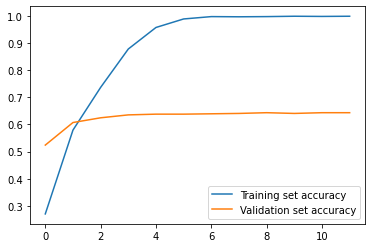

In [0]:
def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()

plot_history(history)

## Predict

In [0]:
# Load best model
model.load_weights('models/BERT_multiclass.h5')

In [0]:
predictions = np.argmax(model.predict(test_inp), axis=1) # np.argmax gives the index which has the highest value e.g. class

In [0]:
predicted_labels = label_encoder.inverse_transform(predictions)
predicted_labels

array(['HI  ', 'PB NA ', 'DT IN ', ..., 'OA NA ', 'PB NA ', 'MT OS '],
      dtype='<U12')

In [0]:
print("Classification accuracy: ", round(accuracy_score(test_label, predicted_labels)*100,1), "percent")

Classification accuracy:  64.8 percent


Accuracy pretty good.

# Milestone 2.2: Error analysis
Compare the errors made by the classifiers you have trained from milestones 1 and 2.1. Are there any patterns? How do the errors one model makes differ from those made by another.



In [0]:
# accuracy
# confusion matrix
# classification_report


# Milestone 3.1: Bert (multi-LABEL)

For milestone 3 we will train two multi-label classifiers, one using non-deep contextual representations, the other using Bert. In this setting, each label is assigned independently. Do hyperparameter optimization on these classifiers.

We selected Support Vector Machine (SVM) to be the non-deep classifier for this milestone. According to [scikit documentation](https://https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) "SVM -- is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes). 

According to the task "each label is assigned independently". We interpreted this to mean, that highlevel and sublevel labels have no connection and did not explore possible (and presumable) connections. 

How ever we skimmed how to improve multilabel classification. According to 
[scikit-multilearn](http://scikit.ml/labelrelations.html): "Multi-label classification tends to have problems with overfitting and underfitting classifiers when the label space is large, especially in problem transformation approaches. A well known approach to remedy this is to split the problem into subproblems with smaller label subsets to improve the generalization quality."
In our case we could improve the classification by training the separate models for high leve and sublevel registers, since the labels are not independent.

Besides of this a priori knowledge relations between classes could be ecplored by scikit-multilearn tools.


## Data preparation for milestone 3

Since we do multi label classification we are dealing with pure highlevel and sublevel registers instead of combinations. This means we have significantly less labels (for example 'NA OP' becomes 'NA' and 'OP') and we have to prepare the data differently from the previous milestones.

For convenience we manipulate the combined data set, where column 'data' holds the information, to which original dataset each row belongs to We will separate all the registers and one hot encode them.

In [0]:
# Clean up the label(register) column:

def from_registers(col):
  lst = col.tolist() # column to list
  registers = [[]] # list of lists, as long as the original column
  idx = 0
  for element in lst:    # NA OP
      parts = element.split(' ') # NA #OP
      for i in parts: 
        if i == '': # omit empty strings
          continue
        registers[idx].append(i) # append to list in list
      if len(lst)-1 > idx : # if we have more labels to separate
        idx = idx+1 
        registers.insert(idx, []) # add new empty list to list
  return registers


In [191]:
# use combined data formed at the beinning of the notebook

print(df.shape)
all_regs=from_registers(df['label']) # use custom made function to list the registers
df['regs'] = all_regs
df.head()

(7564, 3)


,label,text,data,regs
0,DS IG,Logistiikka Jenni Lindholm Laskutus Ritva Lie...,train,"[DS, IG]"
1,RS OP,Tässä [ [ Ortodoksinen seminaari ( Joensuu ) ...,train,"[RS, OP]"
2,NE NA,Koulutuspaikka jokaiselle peruskoulun päättän...,train,"[NE, NA]"
3,SR NA,1 Cardiff C–Everton Tasainen kohde . Cardiff ...,train,"[SR, NA]"
4,MT OS,Northrop Grumman Q4 2009 tulokset Northrop Gr...,train,"[MT, OS]"


Next we will turn those listed registers (column 'regs') to one hot encodings with MultiLabelBinarizer

In [192]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(df['regs']), columns=mlb.classes_, index=df.index)
# join the dummies to original data frame
df = pd.concat([df, dummies], axis=1)
df.head()

,label,text,data,regs,AV,CB,CM,DF,DP,DS,DT,EB,EN,FA,FC,FS,HA,HI,IB,ID,IG,IN,IP,IT,JD,LT,LY,MT,NA,NE,OA,OB,OP,OS,PB,PO,QA,RA,RE,RP,RS,RV,SL,SP,SR,TB
0,DS IG,Logistiikka Jenni Lindholm Laskutus Ritva Lie...,train,"[DS, IG]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,RS OP,Tässä [ [ Ortodoksinen seminaari ( Joensuu ) ...,train,"[RS, OP]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,NE NA,Koulutuspaikka jokaiselle peruskoulun päättän...,train,"[NE, NA]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SR NA,1 Cardiff C–Everton Tasainen kohde . Cardiff ...,train,"[SR, NA]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,MT OS,Northrop Grumman Q4 2009 tulokset Northrop Gr...,train,"[MT, OS]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [193]:
# separate train, test and dev datas from one hot encoded combined dataset

train = df[df['data'] == 'train'] 
test = df[df['data'] == 'test'] 
dev = df[df['data'] == 'dev'] 

# for grid search (maybe not needed/used)
# joint = df[df['data'] != 'test'] 

print(train.shape)
print(test.shape)
print(dev.shape)

(5295, 46)
(1513, 46)
(756, 46)


In [0]:
# separate X (features) and Y (labels) for training data and x and y for development data

# train
X_ = train['text'] # features
Y_ = train.drop(['regs', 'label','text', 'data'], axis=1) # labels

# dev
x_ = dev['text']
y_ = dev.drop(['regs', 'label','text', 'data'], axis=1)

# test
test_feats_ = test['text']
true_labels_ = test.drop(['regs', 'label','text', 'data'], axis=1) # true labels (one-hot encoded) for testing the model predictions
true_regs_ = test['regs']

## Linear support vector machine (SVM)

To do multilabel classification we wrap the SVM with [MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier).


For this milestone we followed [scikit tutorial](https://https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) and this [tutorial](https://www.datatechnotes.com/2020/03/multi-output-classification-with-multioutputclassifier.html).

In [168]:
from sklearn.preprocessing import StandardScaler

# form feature matrixes

vectorizer = TfidfVectorizer(max_features = 20000, ngram_range = (1,1)) 

train_feature_matrix = vectorizer.fit_transform(X_)
dev_feature_matrix = vectorizer.transform(x_)
test_feature_matrix = vectorizer.transform(test_feats_)

# for grid search:
# XG = vectorizer.fit_transform(XG)

# Scale input data for SVM
scaler = StandardScaler(with_mean=False)

train_fm = scaler.fit_transform(train_feature_matrix)
dev_fm = scaler.transform(dev_feature_matrix)
test_fm = scaler.transform(test_feature_matrix)

print("shape of the training data: ", train_fm.shape)
print("shape of the development data: ", dev_fm.shape)
# print("shape of the  data: ", XG.shape)

shape of the training data:  (5295, 20000)
shape of the development data:  (756, 20000)


In [169]:
# guide for multiouput moldel for one hot encoded data: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5 
# and https://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

cat = Y_.columns.values.tolist() # labels/registers
estimator = SGDClassifier(loss='hinge', random_state=42, alpha=0.0001, max_iter=40, early_stopping=True)

testi = MultiOutputClassifier(estimator=estimator)

SGDC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(estimator)),
            ])
for category in cat:
    print("For label {}".format(category))
    # train the model using X_dtm & y
    SVM_pipeline.fit(train_feature_matrix, Y_[category])
    # compute the testing accuracy
    prediction = SVM_pipeline.predict(test_fm)
    print("test accuracy percentage is {}".format(round(accuracy_score(true_labels[category], prediction) *100, 1)))
    cnf = confusion_matrix(true_labels[category], prediction)
    sns.heatmap(cnf)

#round(accuracy_score(true_labels, preds)*100,1), "percent")
#testi.fit(train_feature_matrix, Y)

For label AV


ValueError: ignored

In [0]:
# https://www.datatechnotes.com/2020/03/multi-output-classification-with-multioutputclassifier.html


SGDC = SGDClassifier(loss='hinge', random_state=42, alpha=0.0001, max_iter=40, early_stopping=True)
SGDC_model = MultiOutputClassifier(estimator=SGDC)


#We can check the parameters of the model by the print command.

print(SGDC_model)

In [0]:

SGDC_model.fit(train_feature_matrix, Y)
# training accuracy
print(SGDC_model.score(train_feature_matrix, Y))

SGDC_predictions = model.predict(test_fm)
multilabel_confusion_matrix(true_labels, predictions)

In [0]:


# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html

## Bert (multi-LABEL)

### Data preparation

#### Feature tokenization

In [0]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory
# Maximum number of examples to read
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

In [196]:
# To avoid OOM, truncate one hot encoded data

train = truncate_data(train, MAX_EXAMPLES)
dev = truncate_data(dev, MAX_EXAMPLES)
test = truncate_data(test, MAX_EXAMPLES)

frames = [train, dev, test]
for d in frames:
  print(d.shape)

Note: truncating examples from 5295 to 1500
Note: truncating examples from 1513 to 1500
(1500, 46)
(756, 46)
(1500, 46)


We need to convert our data into a format that BERT understands. Some utility functions are provided to do that.

In [197]:
# remember, INPUT_LENGTH is a parameter for make_model_inputs -function. 
# We also use BERT tokenizer here.

X = make_model_inputs(train['text'])
x = make_model_inputs(dev['text'])
test_inp = make_model_inputs(test['text'])

print(X[0].shape)
print(x[0].shape)
print(test_inp[0].shape)

(1500, 250)
(756, 250)
(1500, 250)


In [0]:
# Print some examples (looks the same as in milestone 2)
print('Token indices:')
print(X[0][:2])
print('Decoded:')
for i in X[0][:2]:
    print(tokenizer.decode(list(i)))
print('Segment ids:')
print(X[1][:2])

Extract one hot label encodings from the truncated data

In [0]:
# train
Y = train.drop(['regs', 'label','text', 'data'], axis=1)

# dev
y = dev.drop(['regs','label','text', 'data'], axis=1)

# test
true_labels = test.drop(['regs', 'label','text', 'data'], axis=1).reset_index(drop=True) # these are used for evaluating model predictions
true_regs = test['regs'].reset_index(drop=True)


### Optimizer

This is the same as in milestone 2

In [0]:
# search for optimal EPOCHS, LEARNING_RATE and BATCH_SIZE for serious training!
# Number of epochs to train for
EPOCHS = 30

# Optimizer learning rate
LEARNING_RATE = 0.00001

# Training batch size
BATCH_SIZE = 16 

In [0]:
# Set the optimizer again if hyperparameters above have been changed from milestone 2

from keras_bert import calc_train_steps, AdamWarmup

total_steps, warmup_steps = calc_train_steps(
    num_example=len(train['text']),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

### Wrap the model

In [0]:
# load the model again if model hyperparameter INPUT_LENGTH has changed
from keras_bert import load_trained_model_from_checkpoint

pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM [masked language modeling] and NSP [next sentence prediction] parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

In [201]:
print(pretrained_model.inputs)

print(pretrained_model.output)

[<tf.Tensor 'Input-Token_1:0' shape=(?, 250) dtype=float32>, <tf.Tensor 'Input-Segment_1:0' shape=(?, 250) dtype=float32>]
Tensor("Encoder-12-FeedForward-Norm_1/add_1:0", shape=(?, 250, 768), dtype=float32)


In [202]:
# model.outputs is a list, here with a single item. Here
# pretrained_model.outputs[0] just grabs that item (the output tensor).
# Indxing that tensor with [:,0] gives the first position in the sequence
# for all elements in the batch (the `:`).

bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice_2:0", shape=(?, 768), dtype=float32)


Once again we wrap the pretrained model. In multi-label classification instead of softmax(), we use sigmoid() to get the probabilities for each label separatedly. Instructions for multilabel classification were read from [Javaid Nabi's blogpost](https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d) and 

In [203]:
num_labels = len(mlb.classes_) # size of the output layer

out = Dense(num_labels, activation='sigmoid')(bert_out) # by calling the output layer we end up calling all the other layers (the model)
model = Model(                                          # sigmoid gives us independent probabilities for each class 
    inputs=pretrained_model.inputs,
    outputs=[out]
)

# Now size of the last layer matches the number of the layers and activation our multilabel purposes
model.output

<tf.Tensor 'dense_3/Sigmoid:0' shape=(?, 42) dtype=float32>

In [0]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy', # one hot encoded labels! Is hamming_loss better?
    metrics=['categorical_accuracy']#, 'binary_accuracy'] #metrics=['binary_accuracy', 'categorical_accuracy'] 
)

# loss functions tried: categorical_crossentropy < binary_crossentropy 
# ordered by test accuracy (treshold set to 0.9) from worst to best

# categorical_crossentropy: Classification accuracy:  17.7 percent

# An important choice to make is the loss function. We use the binary_crossentropy loss and not the usual in multi-class classification 
# used categorical_crossentropy loss. This might seem unreasonable, but we want to penalize each output node independently. So we pick 
# a binary loss and model the output of the network as a independent Bernoulli distributions per label.
# source: https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/

### Train

In [0]:
stop_cb = EarlyStopping(monitor = 'val_categorical_accuracy', patience= 2, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
mc_cb = ModelCheckpoint(filepath='models/BERT_multilabel.h5', monitor='val_categorical_accuracy', verbose=0,save_best_only=True, mode='auto')

history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x, y),
    callbacks=[stop_cb, mc_cb]
)

Train on 1500 samples, validate on 756 samples
Epoch 1/30


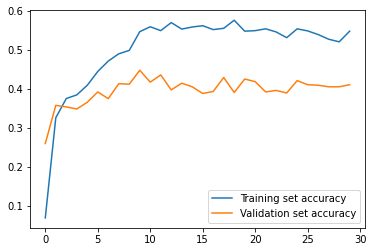

In [46]:
def plot_history(history):
    plt.plot(history.history['categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()

plot_history(history)

Since training accuracy is only 60% it seems the model can't fully utilize training data. Changing BATCH_SIZE to 8 does not improve the results while EPOCHs stay the same.

Activation function could also be optimized. By creating a custom made activation function we could shift and optimize the classification treshold of 50% (default value of sigmoid activation). 

In [0]:
predictions = model.predict(test_inp, batch_size = BATCH_SIZE) # default batch size for predictiong is 32. See Keras documentation

For each input we gain independet probabilities for belonging to each of the labels

In [48]:
print(predictions) 

[[0.02643323 0.06258249 0.00959128 ... 0.00829169 0.00296825 0.00265291]
 [0.00284943 0.08777699 0.00139424 ... 0.00658411 0.02069277 0.04387188]
 [0.03087386 0.05152556 0.01001698 ... 0.0149112  0.00850144 0.00210509]
 ...
 [0.00288862 0.02813721 0.00924307 ... 0.00511223 0.00443214 0.00202966]
 [0.00386298 0.00596645 0.00403318 ... 0.00461656 0.00237945 0.00555652]
 [0.00699678 0.0178611  0.00847417 ... 0.00392848 0.00551081 0.00883442]]


In [49]:
print(sum(predictions[0])) # since we do multiclass, sum of probabilities is over 1

2.0998137295246124


In [50]:
# https://datascience.stackexchange.com/questions/25752/how-does-keras-calculate-accuracy-for-multi-label-classification
# TRY THIS OUT!

# score, acc = model.evaluate(test_inp, true_labels,
#                             batch_size=BATCH_SIZE)
# score

1500/1500 [==============================] - 48s 32ms/sample - loss: 0.0783 - categorical_accuracy: 0.4553


In [73]:
preds = (predictions > 0.50).astype(np.uint8) # predictions will be transformed to one hot encodings with sigmoid treshold, 50%
print("Predictions are binary sequences:\n", preds[1]) 

predicted_labels = mlb.inverse_transform(preds) # inverse transform gives the registers
print("Inverse transform gives the predicted register name(s):\n" ,predicted_labels[0])

Predictions are binary sequences:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0]
Inverse transform gives the predicted register name(s):
 ('HI', 'IN')


In [137]:

type(scipy.sparse.csr_matrix(true_labels))
type(scipy.sparse.csr_matrix(preds))

scipy.sparse.csr.csr_matrix

In [78]:
print("Classification accuracy: ", round(accuracy_score(true_labels, preds)*100,1), "percent") # for accuracy score we use here whole binary sequence

Classification accuracy:  49.7 percent


In [129]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.8MB/s 


In [140]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html

import scipy.sparse
from skmultilearn.utils import measure_per_label
from sklearn.metrics import hamming_loss

print(hamming_loss(true_labels, preds))

measure_per_label(accuracy_score, scipy.sparse.csr_matrix(true_labels), scipy.sparse.csr_matrix(preds))

0.025587301587301586


[0.996,
 0.9686666666666667,
 0.994,
 0.966,
 0.988,
 0.9393333333333334,
 0.938,
 0.9926666666666667,
 0.9826666666666667,
 0.9973333333333333,
 0.9906666666666667,
 0.998,
 0.994,
 0.964,
 0.99,
 0.9633333333333334,
 0.9273333333333333,
 0.858,
 0.992,
 0.9953333333333333,
 0.9973333333333333,
 0.9906666666666667,
 0.9973333333333333,
 0.9913333333333333,
 0.8673333333333333,
 0.9433333333333334,
 0.96,
 0.974,
 0.9213333333333333,
 0.9906666666666667,
 0.9453333333333334,
 0.998,
 0.9933333333333333,
 0.994,
 0.9966666666666667,
 0.992,
 0.9826666666666667,
 0.9773333333333334,
 0.9993333333333333,
 0.9933333333333333,
 0.99,
 0.9946666666666667]

In [0]:
cnfs = multilabel_confusion_matrix(true_labels, preds)
# cnfs.shape # object contains cnf matrix for each label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


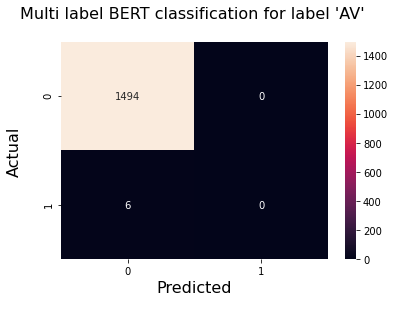

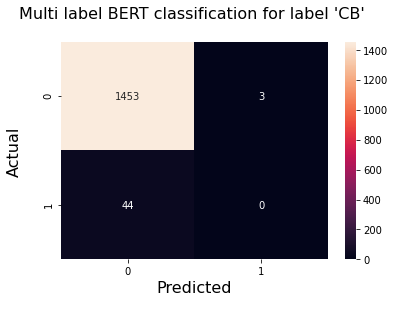

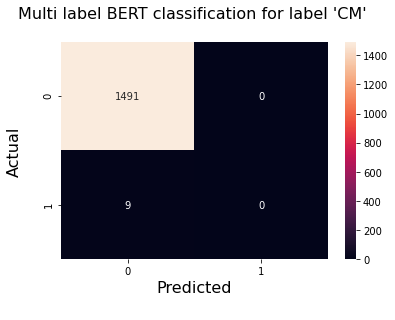

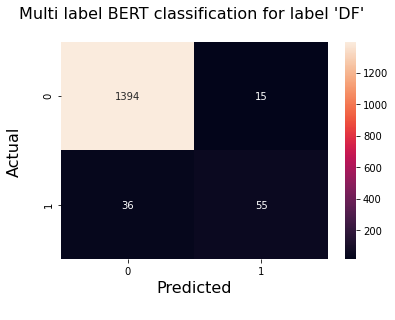

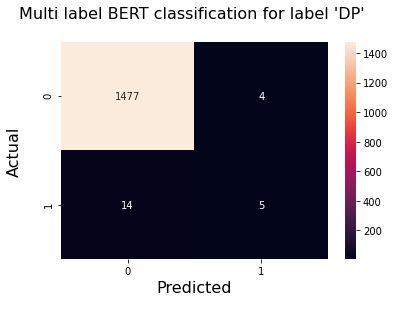

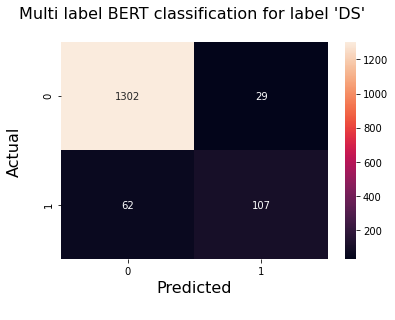

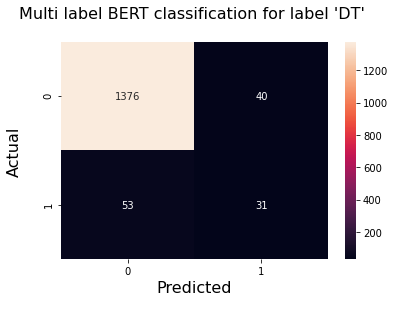

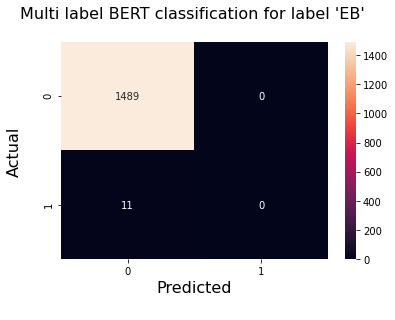

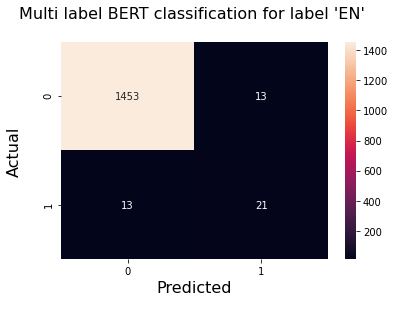

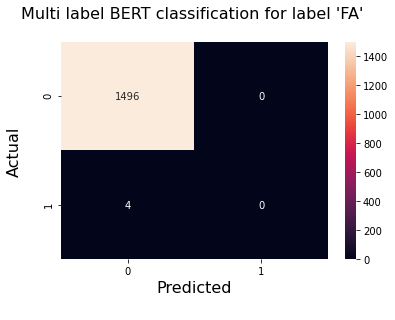

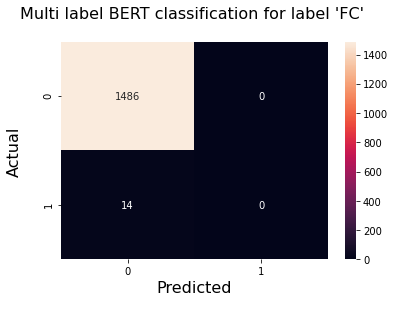

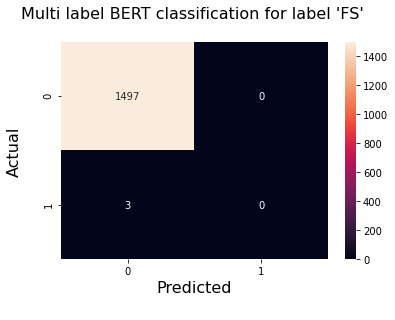

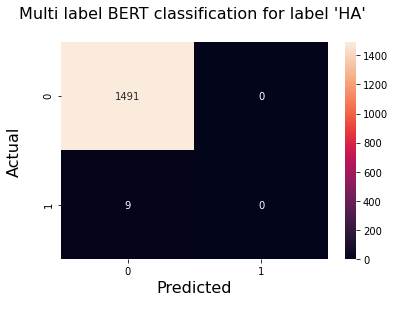

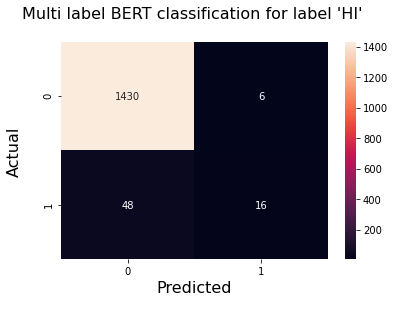

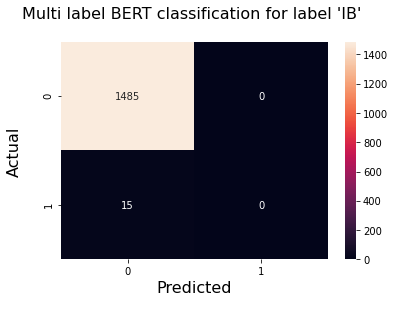

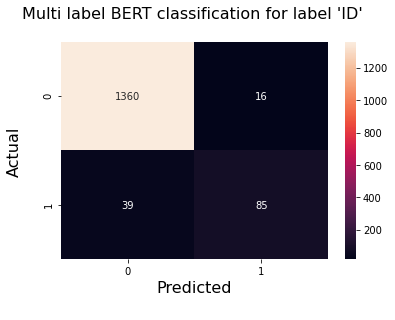

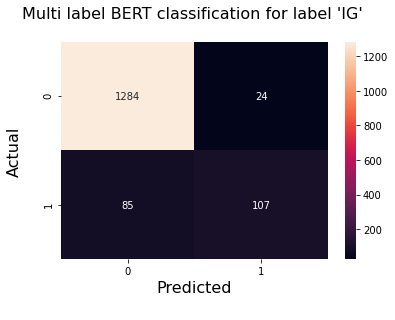

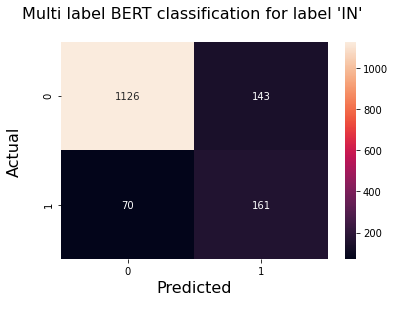

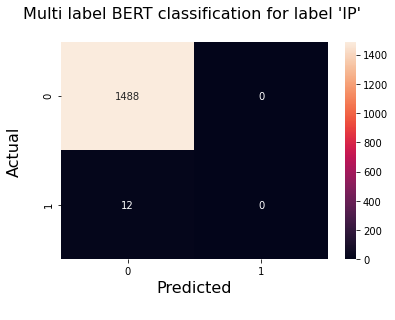

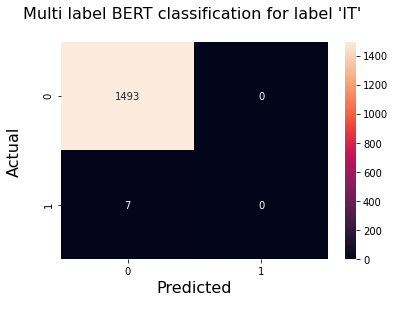

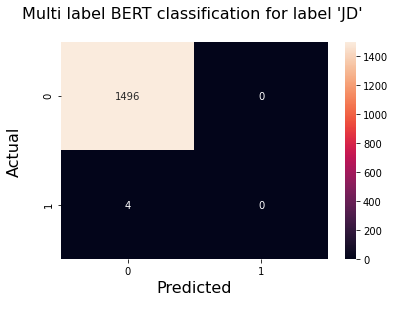

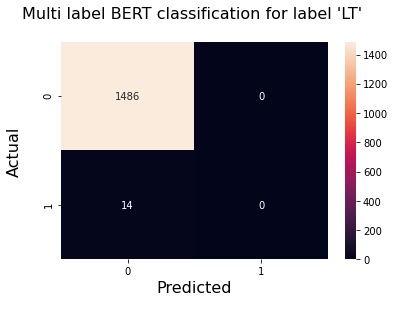

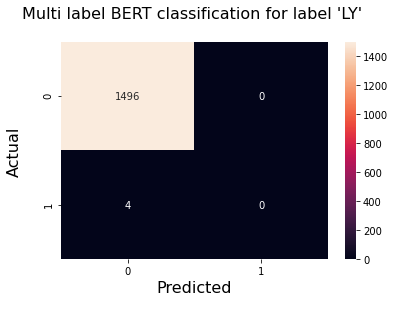

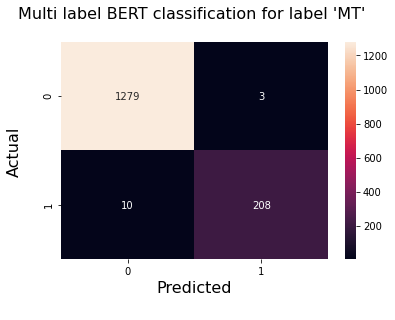

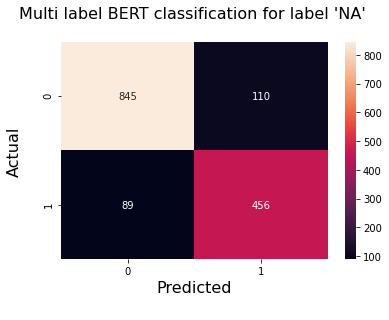

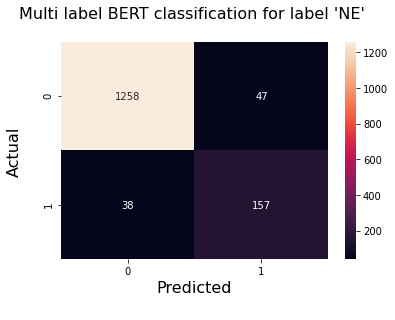

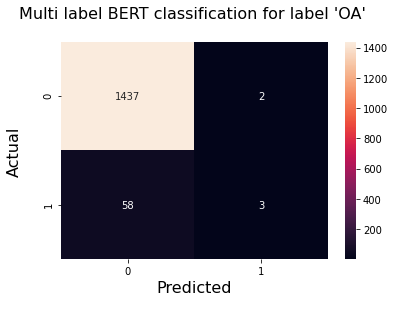

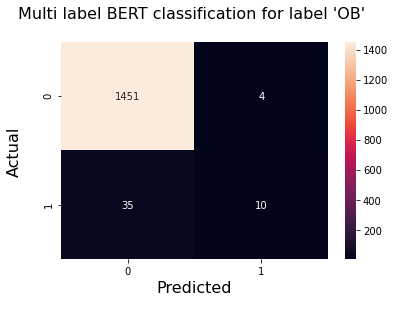

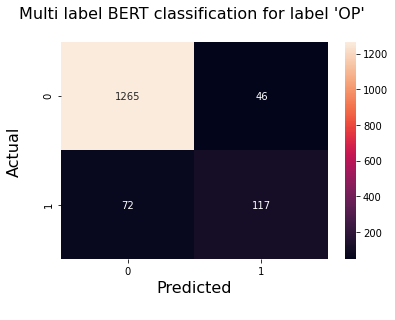

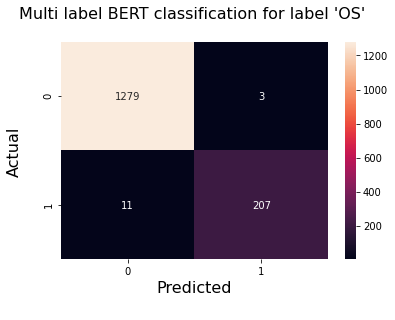

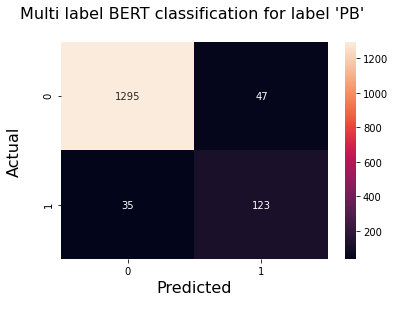

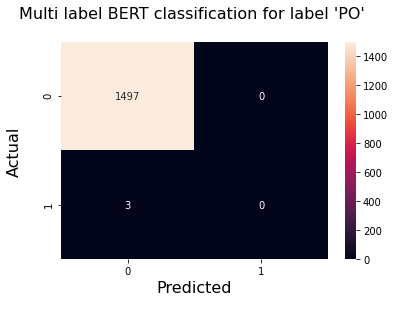

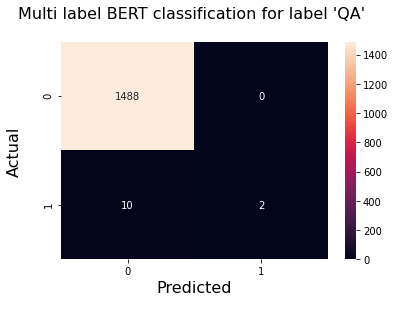

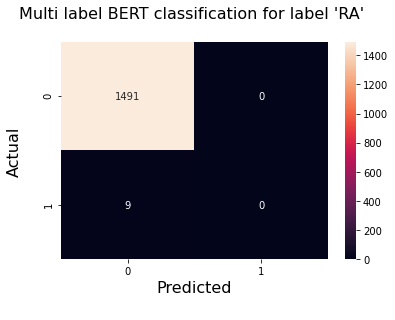

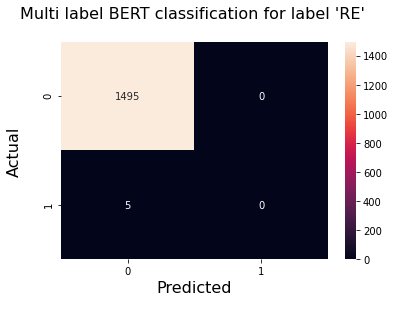

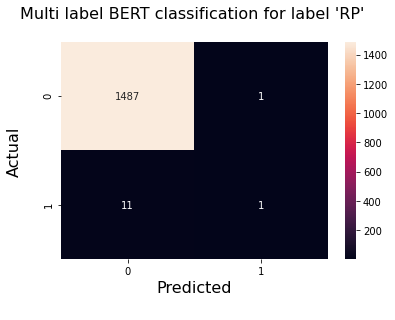

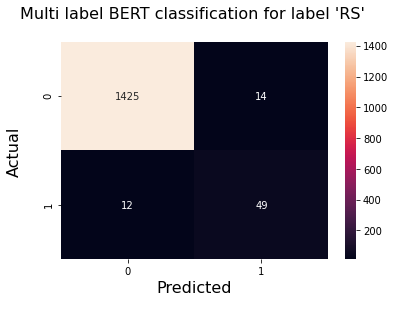

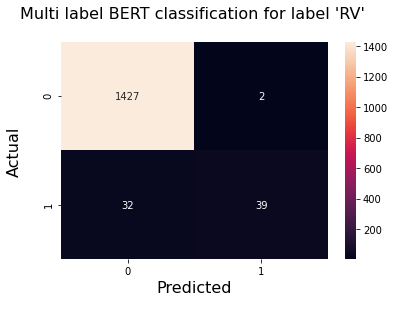

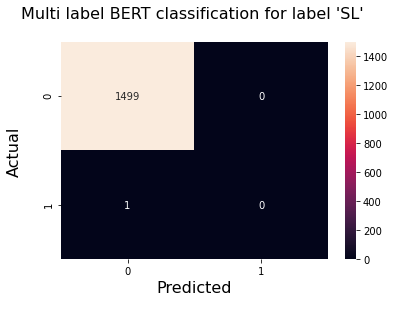

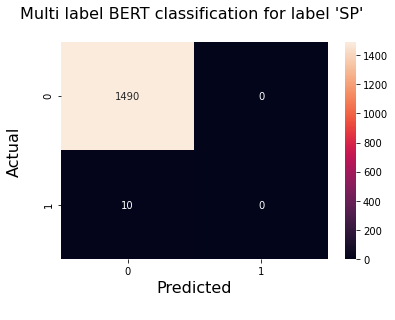

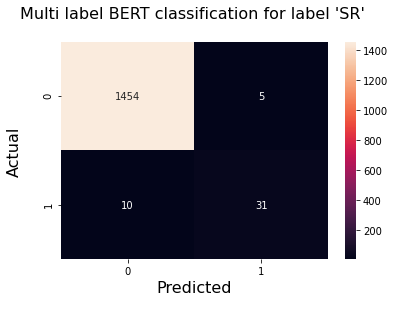

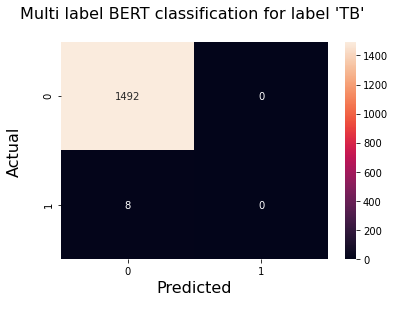

In [120]:
idx = 0

for matrix in cnfs:
  # print(matrix)

  

  label = mlb.classes_[idx]
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix, annot=True, fmt='d')
  plt.title("Multi label BERT classification for label %la \n" % label, fontsize=16)
  plt.ylabel('Actual\n', fontsize=16)
  plt.xlabel('Predicted\n', fontsize=16)
  idx = idx+1
  print()

What are the measure for accuracy of multilabel data? https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data

"When considering the multi label use case, you should decide how to extend accuracy to this case. The method choose in hamming loss was to give each label equal weight. One could use other methods (e.g., taking the maximum).

Since hamming loss is designed for multi class while Precision, Recall, F1-Measure are designed for the binary class, it is better to compare the last one to Accuracy. In general, there is no magical metric that is the best for every problem. In every problem you have different needs, and you should optimize for them." https://stats.stackexchange.com/questions/336820/what-is-a-hamming-loss-will-we-consider-it-for-an-imbalanced-binary-classifier

In [0]:
# true_labels.iloc[0] == preds[0] # binäärit vastaavat toisiaan!

In [0]:
# This is NOT CORRECT!
# for register in mlb.classes_:
#   idx = 0
#   # extract predictions for register from result matrix
#   column = []
#   for row in preds:
#     column.append(row[idx])
#   success = sum(true_labels[register] == column) # for how many input the prediction is correct? NONONOOOOO!
#   acc = round(success/len(true_labels)*100, 1)
#   print('For register {}'.format(register), 'test accuracy is', acc)
#   idx = idx+1







# Milestone 3.2: Model comparison
Compare the results of these two classifiers. Do the two models predict in the same way? Analyze the predictions in terms of label-specific differences.


as mentioned here, the accuracy is ambiguous in the multiple-label case.

The HL thus presents one clear single-performance-value for multiple-label case in contrast to the precision/recall/f1 that can be evaluated only for independent binary classifiers for each label.